In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from skimage import io
import skimage.transform as sktr
import skimage.util as skutil

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from os import path

from sklearn.metrics import confusion_matrix


In [2]:
class SegmWrapper(torch.utils.data.Dataset): # combina 2 seturi de date
  def __init__(self, root, train=True, transform=None, target_transform=None):
    self.root = root
    self.train = train
    self.transform = transform
    self.target_transform = target_transform
    
    # initialize an MNIST wrapper
    self.mnist_dataset = torchvision.datasets.MNIST(root=path.join(self.root, 'mnist'), #numere 0-9 handwriten
                                                    train=self.train, transform=None, 
                                                    target_transform=None,
                                                    download=True)
    # initialize a CIFAR10 wrapper
    self.cifar_dataset = torchvision.datasets.CIFAR10(root=path.join(self.root, 'cifar'), #10 clase de animale
                                                      train=self.train, transform=None, 
                                                      target_transform=None,
                                                      download=True)
    
  def __len__(self):
    return len(self.cifar_dataset)
  
  def __getitem__(self, idx): #suprapunere
    # read mnist image
    mnist_img, _ = self.mnist_dataset[idx]
    # read cifar image
    cifar_img, _ = self.cifar_dataset[idx]
       
    mnist_img = np.array(mnist_img)
    cifar_img = np.array(cifar_img)
    
    # resize mnist image
    mnist_img = sktr.resize(mnist_img, (32,32), preserve_range=True) #avem 32x32 la cifar
    # generate digit ground truth
    mnist_img_thresh = np.zeros_like(mnist_img, dtype=np.long)
    mnist_img_thresh[mnist_img > 125] = 1 

    # # invert cifar pixels where digit is present
    cifar_img_inv = skutil.invert(cifar_img)
    cifar_img[mnist_img_thresh > 0.0] = cifar_img_inv[mnist_img_thresh > 0.0]

    
    if self.transform != None:
      cifar_img = self.transform(cifar_img)
    
    if self.target_transform != None:
      mnist_img_thresh = self.target_transform(mnist_img_thresh)
      
    return cifar_img, mnist_img_thresh
    
    

Extracting ./segm_data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./segm_data/mnist/MNIST/raw


Extracting ./segm_data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./segm_data/mnist/MNIST/raw


Extracting ./segm_data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./segm_data/mnist/MNIST/raw


Extracting ./segm_data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./segm_data/mnist/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./segm_data/cifar/cifar-10-python.tar.gz to ./segm_data/cifar
Sample shape is:  (32, 32, 3)
Max intensity:  255
Min intensity:  0


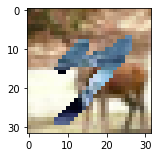

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


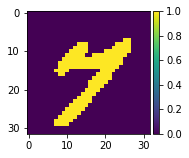

In [3]:
dataset = SegmWrapper('./segm_data', train=True, transform=None, target_transform=None)
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
#            'horse', 'ship', 'truck']

sample, gt = dataset[1001]
sample = np.array(sample)

print('Sample shape is: ', sample.shape)
print('Max intensity: ', sample.max())
print('Min intensity: ', sample.min())

# print(sample)
# print(gt)

fig = plt.figure()
io.imshow(sample)
fig.set_size_inches(2, 2, forward=True)

plt.show()

fig = plt.figure()
io.imshow(gt)
fig.set_size_inches(2, 2, forward=True)

plt.show()


In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((125.3/255., 123.0/255., 113.9/255.,), 
                                     (63.0/255., 62.1/255., 66.7/255.,))
])

trainset = SegmWrapper(root='./segm_data', train=True, 
                       transform=transform, target_transform=None)
testset = SegmWrapper(root='./segm_data', train=False, 
                      transform=transform, target_transform=None)



Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                         shuffle=True, num_workers=1) # un DL stie sa ia un batch de imagini le face shuffle pe 1 thread
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=1)

In [6]:
class SegmModel(nn.Module):
  def __init__(self):
    super(SegmModel, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 16, 5, padding=2, bias=True) #3 channels, 16 outputu, kernel de 5
    self.bn1 = nn.BatchNorm2d(16)
    
    self.conv2 = nn.Conv2d(16,32, 3, padding=1, bias=True)
    self.bn2 = nn.BatchNorm2d(32)
    
    self.conv3 = nn.Conv2d(32,64, 3, padding=1, bias=True)
    self.bn3 = nn.BatchNorm2d(64)
    
    self.fc1 = nn.Conv2d(64, 256, 1, bias=True) #luam imagine mare aplicam filtru si obtinem imagine mai mica
    self.fc2 = nn.Conv2d(256,512, 1, bias=True)
    
    self.up = nn.ConvTranspose2d(512, 512, 16, stride=8, padding=4, output_padding=0, bias=False) #upsampling aplicam filtru -> imagine mai mare ca sa obtinem imaginea

    self.score = nn.Conv2d(512, 2, 1, bias=False) #vrem output de 2 ca avem 2 clase
    
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.bn1(x)
    x = F.max_pool2d(x, 2, stride=2)

    x = self.conv2(x)
    x = F.relu(x)
    x = self.bn2(x)
    x = F.max_pool2d(x, 2, stride=2)

    x = self.conv3(x)
    x = F.relu(x)
    x = self.bn3(x)
    x = F.max_pool2d(x, 2, stride=2)
    
    x = self.fc1(x)
    x = self.fc2(x)

    x = self.up(x)
    
    x = self.score(x)
   
    x = F.log_softmax(x, dim=1) # per pixel si alege din 2 valori adica 2 clase
    
    return x
  


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")

In [8]:
def plot_image_grid(img_data, pred_data, num=4):
  PAD = 8

  grid_data = torchvision.utils.make_grid(img_data[0:num, ...], normalize=True, padding=PAD, pad_value=1.0)
  grid_data = grid_data.numpy().transpose((1,2,0))

  grid_pred = torchvision.utils.make_grid(pred_data[0:num, ...].float(), normalize=False, padding=PAD, pad_value=1.0)
  grid_pred = grid_pred.numpy().transpose((1,2,0)).astype(np.float32)
  
  fig, ax = plt.subplots(2,1)
  ax[0].imshow(grid_data)
  ax[1].imshow(grid_pred)
  
  plt.show()

In [11]:
net = SegmModel()
net.to(device) #Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

optimizer = optim.Adam(net.parameters(), lr=3e-4) # optimizer definition

log_interval = 500 # iterations between successive log prints
epochs = 10 # the number of epochs to train

losses = np.zeros(len(trainloader)*epochs)

net.train() # put network in train mode

for epoch in range(epochs):
  for batch_idx, (data, target) in enumerate(trainloader):
    data, target = data.to(device), target.to(device) # data loading
    optimizer.zero_grad() # set accumulated gradient to zero
    output = net(data) # forward step
    loss = F.nll_loss(output, target) # compute loss
    loss.backward() # backward step
    optimizer.step() # update step
    
    losses[len(trainloader)*epoch+batch_idx] = loss.item()
    
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(trainloader.dataset),
      100. * batch_idx / len(trainloader), loss.item()))
      
      pred = output.max(1, keepdim=True)[1]
      plot_image_grid(data.to(cpu), pred.to(cpu))
      

losses = np.convolve(losses, np.ones((10,))/10, mode='full')
plt.plot(losses)
plt.grid()
plt.title('Training loss')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Test iteration: 0     IoU: 0.5252240359693499


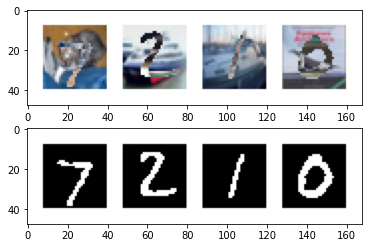

Test iteration: 100     IoU: 0.5408923415752382


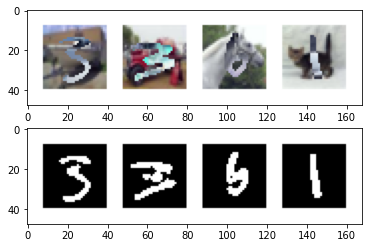

Test iteration: 200     IoU: 0.5446264797745324


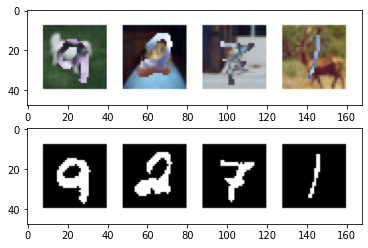

Test iteration: 300     IoU: 0.5204021885970712


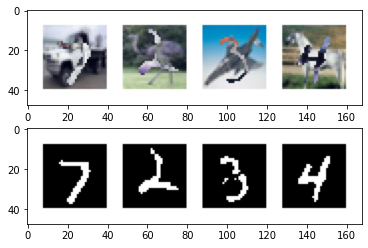

Test iteration: 400     IoU: 0.5532195620285406


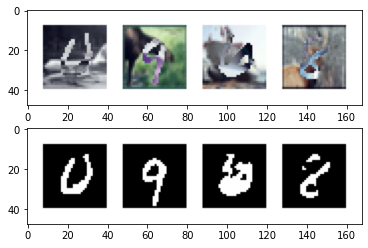

Test iteration: 500     IoU: 0.5705804297634562


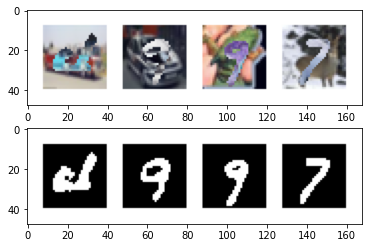

Test iteration: 600     IoU: 0.5270502324854156


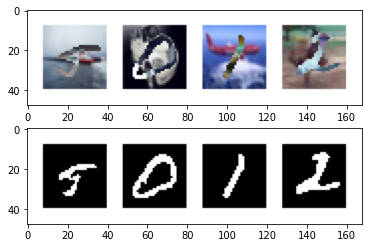


Test set average IoU: 0.547341887303138



In [12]:
net.eval() # put network in evaluation (test) mode 
test_loss = 0

intersection = np.zeros(2)
union = np.zeros(2)
IoU = np.zeros(2)

log_interval = 100

with torch.no_grad(): # don't compute gradients
  for batch_idx, (data, target) in enumerate(testloader):
    data, target = data.to(device), target.to(device) #  data loading
    output = net(data) # forward step
    test_loss += F.nll_loss(output, target, reduction='sum').item() # loss computation (sums up batch loss)
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    for i in range(2):
      intersection[i] = ((pred == i) & (target == i)).sum()
      union[i] = ((pred == i) | (target == i)).sum()
      
    IoU_it = intersection / union  
    IoU = IoU + IoU_it
    
    if batch_idx % log_interval == 0:
      print('Test iteration: {}     IoU: {}'.format(
      batch_idx, np.mean(IoU_it)))
      
      pred = output.max(1, keepdim=True)[1]
      plot_image_grid(data.to(cpu), pred.to(cpu))
      
  test_loss /= len(testloader.dataset)
  IoU /= len(testloader)
  print('\nTest set average IoU: {}\n'.format(np.mean(IoU)))